In [1]:
%reset -f

In [2]:
%load_ext memory_profiler
#### CNN for CHAMPS Data Set ####
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import multiprocessing as mp
import functools as ft
import time as t
import pickle
# ML Packages
# from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.model_selection import cross_val_score, GridSearchCV
# Neural Net Stuff
import tensorflow as tf
%load_ext tensorboard
!rm -rf ./logs/
!mkdir ./logs/

# Constrain GPU Memory Usage
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Import and Initialize Parallel Pandas Stuff
import dask.dataframe as ddk

# Debug Stuff
# from IPython.core.debugger import set_trace

# Global Variable Declarations
f_path = "~/Desktop/Kaggle_Data/CHAMPS/" # local location of Kaggle Data
numpy_fpath = "/home/aj/Desktop/Kaggle_Data/CHAMPS/NUMPY_ARRAYS/" # local numpy array save spot
step_size = 0.5 # step size for building position array and model inputs
steps = np.arange(0, 30, step_size)
column_dict = {'1': 'rank_1', '2': 'rank_2', '3': 'rank_3', 'HH': 'pair_HH', 'HC': 'pair_HC', 'HN': 'pair_HN'} # For Building Atom Type and Coupling Type Features

#### Load Position Matrix if On File; Otherwise Build It ####
try:
    position_matrix = np.load(numpy_fpath + "position_matrix_" + str(step_size) + "step_size.npy")
except IOError:
    position_matrix = np.zeros((len(steps), len(steps), len(steps), 3), dtype=np.float32)
    for ijk in np.ndindex(position_matrix.shape[:3]):
        position_matrix[ijk] = np.asarray(ijk, dtype=np.float32)*step_size
    np.save(numpy_fpath + "position_matrix_" + str(step_size) + "step_size.npy", position_matrix)
##############################################################

# Function for Potential Calculations
# potential_function = np.vectorize(lambda x: 0.8909*(np.power((0.8909/x),12)-np.power((0.8909/x), 6)) if x > 0.817794 else np.float32(1.05)) # The 1.05 is to represent a non-physical region
# Global Factors
pot_function_factor = np.float32(0.8909)
pot_factor_12 = np.power(pot_function_factor, 12)
pot_factor_6 = np.power(pot_function_factor, 6)

# Callback Functions for Tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')

# Global Names for Saves & Callbacks
model_name = 'champs_cnn_4CL_kernal_15-6__MidDNN_50_featDNN_50-25_100-25_ss_' + step_size
model_epochsteps = '500e50s'
model_batchsize = 'batch10'
model_date = '06092020'

# For Multiprocessing Error Bypass (Why is it Even Happening??)
os.sys.modules['__main__'].__spec__ = None

In [3]:
# Load in Data
training_df = pd.read_csv(f_path + "train.csv", index_col='id')
structures_df = pd.read_csv(f_path + "structures.csv") # Structure Data Treated As Global; Includes All Molecules, even Test Set
# When you're ready to test
# testing_df = pd.read_csv(f_path + "test.csv")

/home/aj/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
# Preprocess Some of the Datafram

# Get List of Unique Molecules
unique_molecules = training_df['molecule_name'].unique()

# Map the Coupling info Into the DataFrame
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures_df, how = 'left', left_on = ['molecule_name', f'atom_index_{atom_idx}'], right_on = ['molecule_name',  'atom_index'])
    df = df.drop('atom_index', axis=1)
    # Rename Columns as Needed
    df = df.rename(columns={'atom': f'atom_{atom_idx}', 'x': f'x_{atom_idx}', 'y': f'y_{atom_idx}', 'z': f'z_{atom_idx}'})
    return df

def one_hot_encoding_for_rank_pair(series):
    type_split = series['type'].split('J')
    series[column_dict[type_split[0]]] = 1
    series[column_dict[type_split[1]]] = 1
    return series

def build_champs_features(df):
    # Map Training DataFrame to Structure Info
    df = map_atom_info(df, 0)
    df = map_atom_info(df, 1)

    # Add Atomic Distance Feature
    vector_atom_0 = df[['x_0','y_0','z_0']].values
    vector_atom_1 = df[['x_1','y_1','z_1']].values
    df['atom_dist'] = np.linalg.norm(vector_atom_0 - vector_atom_1, axis=1)

    # Move Origin For Image Building Purposes
    df[['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1']] = df[['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1']]+15

    # One-Hot Encode Unique Types
    df = df.assign(**pd.DataFrame(0, columns=['rank_1', 'rank_2', 'rank_3', 'pair_HH', 'pair_HC', 'pair_HN'], index=training_df.index))
    # Parallalize the Apply on Dataframe
    dask_df = ddk.from_pandas(df, mp.cpu_count())
    df = dask_df.apply(one_hot_encoding_for_rank_pair, axis=1, meta=dask_df).compute(scheduler='processes')
           
    return df

# Build Features On Training Set
training_df = build_champs_features(training_df)

print("#####################################################################################################")
print(training_df[['molecule_name', 'scalar_coupling_constant', 'rank_1', 'rank_2', 'rank_3', 'pair_HH', 'pair_HC', 'pair_HN']].head())
feat_toKeep = ['atom_dist', 'rank_1', 'rank_2', 'rank_3', 'pair_HH', 'pair_HC', 'pair_HN']
print("#####################################################################################################")

#####################################################################################################
      molecule_name  scalar_coupling_constant  rank_1  rank_2  rank_3  \
0  dsgdb9nsd_000001                   84.8076       1       0       0   
1  dsgdb9nsd_000001                  -11.2570       0       1       0   
2  dsgdb9nsd_000001                  -11.2548       0       1       0   
3  dsgdb9nsd_000001                  -11.2543       0       1       0   
4  dsgdb9nsd_000001                   84.8074       1       0       0   

   pair_HH  pair_HC  pair_HN  
0        0        1        0  
1        1        0        0  
2        1        0        0  
3        1        0        0  
4        0        1        0  
#####################################################################################################


In [5]:
# Function to Build Batch of Images
def build_potmap(rest, series):
    # Get Pair Vectors from Series Passed In
    pair_v = [series[['x_0', 'y_0', 'z_0']].values.tolist(), series[['x_1', 'y_1', 'z_1']].values.tolist()]
    # Start Building Images
    others_v = [x for x in rest if x not in pair_v]

    # Track Time
    # start_time = t.perf_counter()
    # Build Potential Map (Dual Channel)
    others_potmap = np.zeros((len(steps), len(steps), len(steps)), dtype=np.float32)
    for o_vec in others_v:
        # For Modified Lennard Jones Potential
        norm_tensor = tf.norm(tf.subtract(position_matrix, np.asarray(o_vec)), axis=3)
        pot_map_calc = tf.multiply(tf.subtract(tf.multiply(tf.math.reciprocal_no_nan(tf.pow(norm_tensor, np.float32(12))), pot_factor_12), tf.multiply(tf.math.reciprocal_no_nan(tf.pow(norm_tensor, np.float32(6))), pot_factor_6)), pot_function_factor)
        pot_map_decide = tf.where(norm_tensor < np.float32(0.817794), np.float32(1.05), pot_map_calc)
        others_potmap = tf.add(others_potmap, pot_map_decide)
        
        # others_potmap = np.add(others_potmap, potential_function(np.linalg.norm(np.subtract(position_matrix, np.asarray(o_vec)), axis=3)))
    
    pair_potmap = np.zeros((len(steps), len(steps), len(steps)), dtype=np.float32)
    for p_vec in pair_v:
        # For Modified Lennard Jones Potential
        norm_tensor = tf.norm(tf.subtract(position_matrix, np.asarray(p_vec)), axis=3)
        pot_map_calc = tf.multiply(tf.subtract(tf.multiply(tf.math.reciprocal_no_nan(tf.pow(norm_tensor, np.float32(12))), pot_factor_12), tf.multiply(tf.math.reciprocal_no_nan(tf.pow(norm_tensor, np.float32(6))), pot_factor_6)), pot_function_factor)
        pot_map_decide = tf.where(norm_tensor < np.float32(0.817794), np.float32(1.05), pot_map_calc)
        pair_potmap = tf.add(pair_potmap, pot_map_decide)
        
        # pair_potmap = np.add(pair_potmap, potential_function(np.linalg.norm(np.subtract(position_matrix, np.asarray(p_vec)), axis=3)))
    
    pot_total = np.stack((pair_potmap, others_potmap), axis=-1)
    
    # Save Dual Channel "Picture" to Disk
    # tmp_pic_name = numpy_fpath + "potential_map_" + unique_molecules[unique_mol_index] + "_" + "PairIndex_" + str(atm_index1) + "_" + str(atm_index2) + "__" + str(step_size) + "_step.npy"
    # np.save(tmp_pic_name, pot_total)

    # Track Time
    # end_time = t.perf_counter()
    # print(f'Processing Time for Potential Map of Pair {pair_v}: {np.round(end_time-start_time, 2)} Seconds')
    series['pot_map'] = pot_total
    return series

In [6]:
# Function to Build Batch for CNN Training
def build_batch(df, from_file=False):
    if from_file == False:
        while True:
            the_data = create_data(df)
            for _ in range(10):
                the_data = the_data.concatenate(create_data(df))
        
            the_data = the_data.shuffle(tf.data.experimental.cardinality(the_data))
            # Here is Iterator for Data Generation During Training
            for i in the_data.batch(10):
                yield i
    else:
        file_iterator = 0
        while True:
            fromFile_df = pd.read_pickle('~/Desktop/CHAMPS_DataOnDisk/CHAMPS_PotMap_Included_' + str(file_iterator) +'_.pkl')
            input_dataset = tf.data.Dataset.from_tensor_slices({'feat_input':fromFile_df[feat_toKeep].astype(np.float32).values, 'pic_input': tf.stack(fromFile_df.pop('pot_map').tolist())})
            target_dataset = tf.data.Dataset.from_tensor_slices(fromFile_df['scalar_coupling_constant'].astype(np.float32).values)
            dataset_fromFile = tf.data.Dataset.zip((input_dataset, target_dataset))
            dataset_fromFile = dataset_fromFile.shuffle(tf.data.experimental.cardinality(dataset_fromFile))
            file_iterator = file_iterator + 1
            for i in dataset_fromFile.batch(10):
                yield i

def create_data(df, which_set='train'):
    # Check if Train, Test, or Validation
    if which_set == 'test':
        i = np.random.randint(69001, 85012)
    elif which_set == 'val':
        i = np.random.randint(68000, 69000)
    else:
        i = np.random.randint(0, 68000)
    
    # Choose Subset of Data
    training_subset = df[df['molecule_name'] == unique_molecules[i]].copy()
    # Get All Vector Positions of Atoms
    rest_of_vectors = np.unique(np.concatenate((training_subset[['x_0', 'y_0', 'z_0']].values, training_subset[['x_1', 'y_1', 'z_1']].values), axis=0), axis=0)
    # Define a Partial Where rest_of_vectors Doesn't Change
    build_potmap_partial = ft.partial(build_potmap, rest_of_vectors.tolist())
    # print("######################################################################")
    # print(f'Batch has {len(rest_of_vectors)} Atoms in Molecule.')
    # print("######################################################################")

    # Call Total Vectorized Function to Build Batch Pot Images
    training_subset['pot_map'] = 0.0
    
    # start_time = t.perf_counter()
    #######################################################################################
    # if training_subset.shape[0] > mp.cpu_count():
    #     dask_df = ddk.from_pandas(training_subset, mp.cpu_count())
    # else:
    #     dask_df = ddk.from_pandas(training_subset, training_subset.shape[0])
    
    # training_subset = dask_df.apply(build_potmap_partial, axis=1, meta=dask_df).compute(scheduler='processes')
    training_subset = training_subset.apply(build_potmap_partial, axis=1)
    ########################################################################################
    # end_time = t.perf_counter()
    # print("Creating Data took {} Seconds".format(np.round(end_time-start_time, 2)))
    
    # print("######################################################################")
    # print("Number of Pairs Calculated: {}".format(len(training_subset['pot_map'])))
    # print("######################################################################")
    
    if which_set != 'save':
        input_dataset = tf.data.Dataset.from_tensor_slices({'feat_input':training_subset[feat_toKeep].astype(np.float32).values, 'pic_input': tf.stack(training_subset.pop('pot_map').tolist())})
        target_dataset = tf.data.Dataset.from_tensor_slices(training_subset['scalar_coupling_constant'].astype(np.float32).values)
        zipped_dataset = tf.data.Dataset.zip((input_dataset, target_dataset))
    
    # Return Appropriate Result for which_set
    if (which_set == 'test') or (which_set == 'val'):
        return zipped_dataset.batch(10)
    elif (which_set == 'save'):
        return training_subset
    else:
        return zipped_dataset


In [7]:
# To Build Data to Put on Disk to Free up GPU Memory During Training.
def build_data_for_disk(df, num_sets=5):
    print("Building Data to Put on HDD...")
    for i in range(num_sets):# To Build Data on Disk; Need 37500 items for Full Training
        building_data = create_data(df, 'save')
        while building_data.shape[0] < 5000:
            # start_time = t.perf_counter()
            building_data = pd.concat([building_data, create_data(df, 'save')])
            # print("Iteration Passed...")
            # print("Size of Building_Data: {}".format(building_data.shape[0]))
            # end_time = t.perf_counter()
            # print("It took {} seconds.".format(np.round(end_time-start_time, 2)))
    
        building_data.to_pickle('~/Desktop/CHAMPS_DataOnDisk/CHAMPS_PotMap_Included_' + str(i) + '_SS' + step_size +'.pkl') # Five is Interference for Start of File Name after Some Files already Created
        del building_data
    print("Done Building Data to Put on HDD.")
    print('')

In [8]:
# Temp (How Much is the 0.1 Step Size Data)
# build_data_for_disk(training_df, 1)

In [9]:
# Define CNN Keras Model for CHAMPS Data
def build_cnn_model(m_type='cnn_standard'):
    # Build ML Model Here;
    if m_type == 'cnn_standard':
        # Build a simple model so input types can be compared for performance
        input_pic = tf.keras.layers.Input(shape=(len(steps), len(steps), len(steps), 2), name="pic_input")
        conv_pic1 = tf.keras.layers.Conv3D(16, 3, padding="same", activation="relu", data_format="channels_last")(input_pic)
        conv_pic2 = tf.keras.layers.Conv3D(32, 3, padding="same", activation="relu")(conv_pic1)
        # conv_pool1 = tf.keras.layers.MaxPool3D(pool_size=(2,2,2), padding="same", data_format="channels_last")(conv_pic2)
        conv_pic3 = tf.keras.layers.Conv3D(64, 3, padding="same", activation="relu")(conv_pic2)
        conv_pic4 = tf.keras.layers.Conv3D(128, 3, padding="same", activation="relu")(conv_pic3)
        # conv_pool2 = tf.keras.layers.MaxPool3D(pool_size=(2,2,2), padding="same", data_format="channels_last")(conv_pic4)
        flatten_conv = tf.keras.layers.Flatten()(conv_pic4)
        # Push Layers to DNN for Output
        preout3 = tf.keras.layers.Dense(100, activation="relu")(flatten_conv)
        preout_dropout1 = tf.keras.layers.Dropout(0.25)(preout3)
        preout2 = tf.keras.layers.Dense(50, activation="relu")(preout_dropout1)
        preout_dropout2 = tf.keras.layers.Dropout(0.25)(preout2)
        preout1 = tf.keras.layers.Dense(25, activation="relu")(preout_dropout2)
        output = tf.keras.layers.Dense(1, name="output")(preout1)
        c_model = tf.keras.Model(inputs=[input_pic], outputs=output)
        c_model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
    else:
        # Input for Coupling Type, Etc.
        input_desc = tf.keras.layers.Input(shape=(7,), name="feat_input")
        hidden_desc1 = tf.keras.layers.Dense(50, activation="relu")(input_desc)
        dropout_1 = tf.keras.layers.Dropout(0.25)(hidden_desc1)
        hidden_desc2 = tf.keras.layers.Dense(25, activation="relu")(dropout_1)
        # Input for Potential Map Picture
        input_pic = tf.keras.layers.Input(shape=(len(steps), len(steps), len(steps), 2), name="pic_input")
        conv_pic1 = tf.keras.layers.Conv3D(16, 3, padding="same", activation="relu", data_format="channels_last")(input_pic)
        conv_pic2 = tf.keras.layers.Conv3D(32, 3, padding="same", activation="relu")(conv_pic1)
        conv_pool1 = tf.keras.layers.MaxPool3D(pool_size=(2,2,2), padding="same", data_format="channels_last")(conv_pic2)
        conv_pic3 = tf.keras.layers.Conv3D(64, 3, padding="same", activation="relu")(conv_pool1)
        conv_pic4 = tf.keras.layers.Conv3D(128, 3, padding="same", activation="relu")(conv_pic3)
        conv_pool2 = tf.keras.layers.MaxPool3D(pool_size=(2,2,2), padding="same", data_format="channels_last")(conv_pic4)
        flatten_conv = tf.keras.layers.Flatten()(conv_pool2)
        # Concatenate the Layers and Move to Output
        conv_toDNN1_flatten = tf.keras.layers.Flatten()(conv_pool1)
        conv_toDNN1 = tf.keras.layers.Dense(50, activation="relu")(conv_toDNN1_flatten)
        concat = tf.keras.layers.Concatenate(axis=1)([hidden_desc2, flatten_conv, conv_toDNN1])
        preout3 = tf.keras.layers.Dense(100, activation="relu")(concat)
        preout_dropout1 = tf.keras.layers.Dropout(0.25)(preout3)
        preout2 = tf.keras.layers.Dense(50, activation="relu")(preout_dropout1)
        preout_dropout2 = tf.keras.layers.Dropout(0.25)(preout2)
        preout1 = tf.keras.layers.Dense(25, activation="relu")(preout_dropout2)
        output = tf.keras.layers.Dense(1, name="output")(preout1)
        c_model = tf.keras.Model(inputs=[input_desc, input_pic], outputs=output)
        c_model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
    
    return c_model

champs_model = build_cnn_model('Something_Else')
%memit champs_model

peak memory: 2174.71 MiB, increment: 0.02 MiB


In [10]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 2836), started 16 days, 18:20:09 ago. (Use '!kill 2836' to kill it.)

In [ ]:
# Decide if Will Build Data to Put on HDD
# build_data_for_disk(training_df, 10)
# Callback Function for Model Save
checkpoint_saves = tf.keras.callbacks.ModelCheckpoint(model_name + "_" + model_epochsteps + "_" + model_batchsize + "_" + model_date + "_model.h5", save_best_only=True)
# Get Validation Data for Training Model
print("Get Validation Data...")
val_data = create_data(training_df, 'val')
# Train Model
print("Training Model Input... ")
# With or Without Callback Save Points
history = champs_model.fit(build_batch(training_df, False), epochs=500, steps_per_epoch=50, validation_data=val_data, callbacks=[checkpoint_saves, tensorboard_callback]) #, use_multiprocessing=True, max_queue=50, workers=32)

# Save Model History for Graphing Data Later
with open(model_name + "_" + model_epochsteps + "_" + model_batchsize + "_" + model_date + "_model_history", 'wb') as model_history:
    pickle.dump(history.history, model_history)

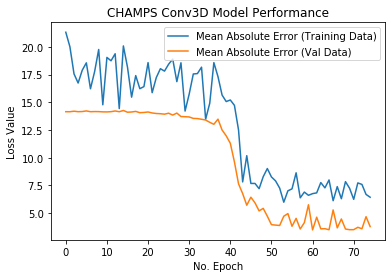

In [12]:
# Plot Things
plt.plot(history.history['loss'][:], label='Mean Absolute Error (Training Data)')
plt.plot(history.history['val_loss'][:], label='Mean Absolute Error (Val Data)')
plt.title('CHAMPS Conv3D Model Performance')
plt.ylabel('Loss Value')
plt.xlabel('No. Epoch')
plt.legend(loc="upper right")
plt.show()

In [70]:
# Get Some Test Cases to See if Model is Moving in Right Direction
results_df = pd.DataFrame(data=None, columns=feat_toKeep + ['coupling_const', 'val_pred', 'abs_error'], dtype=np.float32)
for bottle in range(500):
    predict_batch = create_data(training_df, 'test')
    for i, j in predict_batch.take(500):
        val_pred = champs_model.predict(i)

        j = np.reshape(j, (j.numpy().shape[0],1))
        result_matrix = np.concatenate([i['feat_input'].numpy(), j, val_pred, np.abs(val_pred-j)], axis=-1)
        results_df = results_df.append(pd.DataFrame(data=result_matrix, columns=feat_toKeep + ['coupling_const', 'val_pred', 'abs_error'], dtype=np.float32))

print(results_df.head())

   atom_dist  rank_1  rank_2  rank_3  pair_HH  pair_HC  pair_HN  \
0   1.093396     1.0     0.0     0.0      0.0      1.0      0.0   
1   2.162632     0.0     1.0     0.0      0.0      1.0      0.0   
2   1.776603     0.0     1.0     0.0      1.0      0.0      0.0   
3   1.773167     0.0     1.0     0.0      1.0      0.0      0.0   
4   3.080088     0.0     0.0     1.0      1.0      0.0      0.0   

   coupling_const   val_pred  abs_error  
0       86.864601  82.067390   4.797211  
1       -4.198840  -0.043191   4.155649  
2      -11.909400  -0.084086  11.825315  
3      -10.822900   0.066411  10.889311  
4       11.724900   2.007081   9.717819  


1.2911495412536662
1.2911495412536662
2.3326206491083536
2.985058332085199
3.141993584107487


/home/aj/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/aj/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aj/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


3.759496583332627
4.282189085737136
4.384725884342724


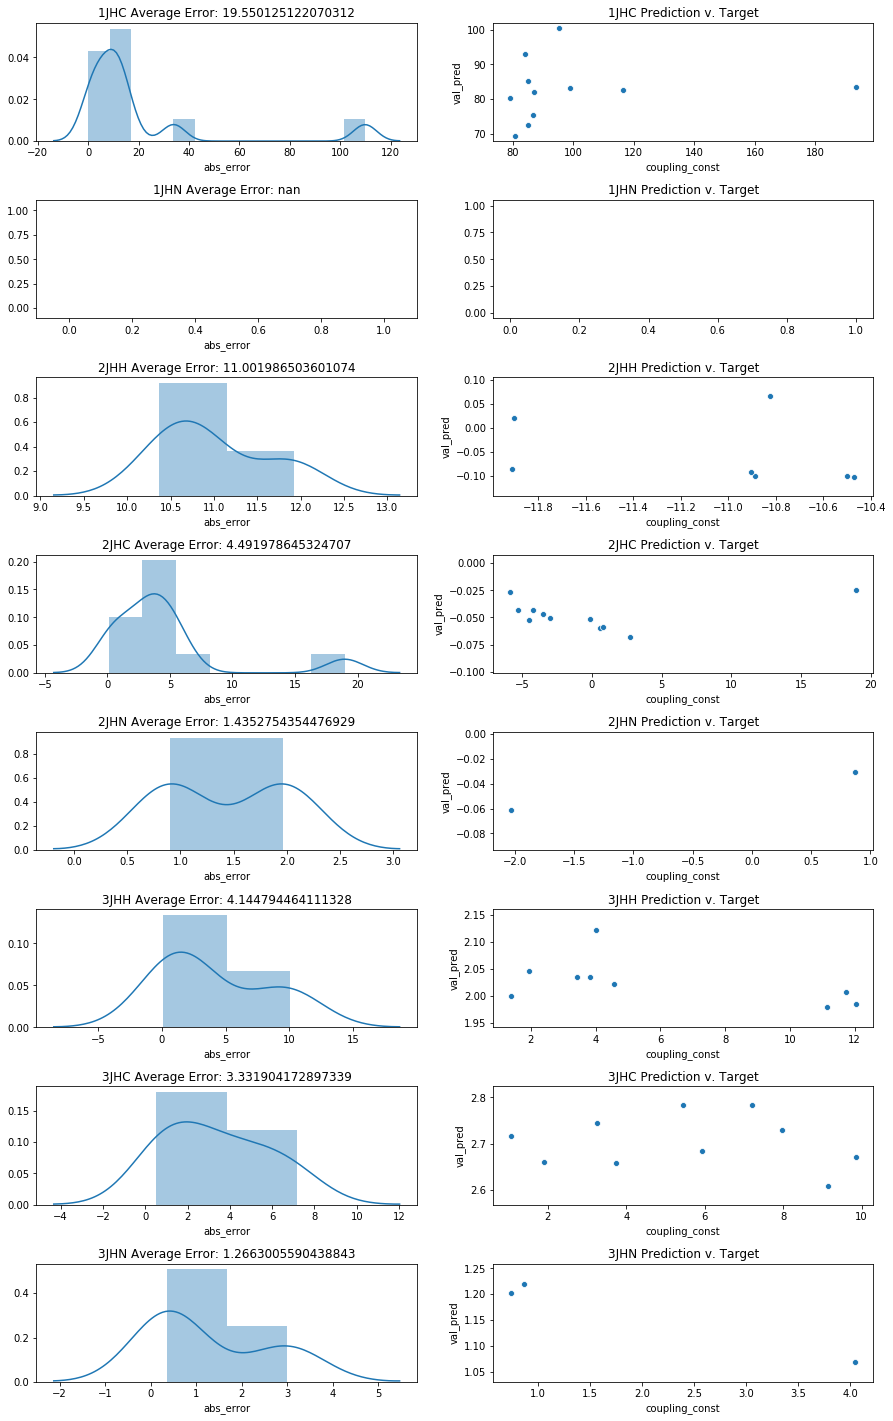

In [127]:
# feat_toKeep = ['atom_dist', 'rank_1', 'rank_2', 'rank_3', 'pair_HH', 'pair_HC', 'pair_HN']
axes_df = list(range(8))
ax = list(range(16))
fig = plt.figure(figsize=(15, 25))
grid = gridspec.GridSpec(8, 2, figure=fig, hspace=0.5)
total_score = 0

selection_string = [['rank_1', 'pair_HC'], ['rank_1', 'pair_HN'], ['rank_2', 'pair_HH'], ['rank_2', 'pair_HC'], ['rank_2', 'pair_HN'], ['rank_3', 'pair_HH'], ['rank_3', 'pair_HC'], ['rank_3', 'pair_HN']]
rank_dict = {'rank_1': 1, 'rank_2': 2, 'rank_3': 3}
type_dict = {'pair_HH':'HH', 'pair_HC':'HC', 'pair_HN':'HN'}
for n in range(8):
    axes_df[n] = results_df[(results_df[selection_string[n][0]] != 0.0) & (results_df[selection_string[n][1]] != 0.0)]
    abs_average_error = axes_df[n]['abs_error'].mean()
    ax[2*n] = plt.subplot(grid[2*n])
    ax[2*n].set_title("{}J{} Average Error: {}".format(rank_dict[selection_string[n][0]], type_dict[selection_string[n][1]], abs_average_error))
    sns.distplot(axes_df[n]['abs_error'], ax=ax[2*n])
    
    ax[2*n+1] = plt.subplot(grid[2*n+1])
    ax[2*n+1].set_title("{}J{} Prediction v. Target".format(rank_dict[selection_string[n][0]], type_dict[selection_string[n][1]]))
    sns.scatterplot(x="coupling_const", y="val_pred", data=axes_df[n], ax=ax[2*n+1])
    
    if np.isnan(abs_average_error):
        abs_average_error = 1
    total_score = total_score + np.log10(abs_average_error)

total_score = total_score/8.0

In [128]:
print("The Total Score of the Model this Run was: {}".format(total_score))

The Total Score of the Model this Run was: 0.5480907355428405
